# Préliminaires

- ## Introduction :

Dans cette partie nous allons gérer l'approche naïve de l'apprentissage avec très peu de modifications sur la donnée. Nous tenterons par la suite d'effectuer un travail plus réfléchi sur la donnée dans l'optique d'obtenir un meilleur score.

- ## Précautions

Ce notebook prend beaucoup de temps à être exécuté dans son intégralité du fait des apprentissages successifs qui sont lancés. Il est conseiller de ne pas l'exécuter et d'observer directement les résultats des cellules.

- ## Imports des librairies utiles

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/duc-vinh/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



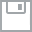
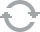
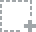
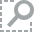
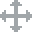
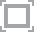
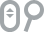
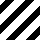
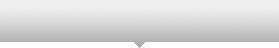
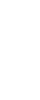
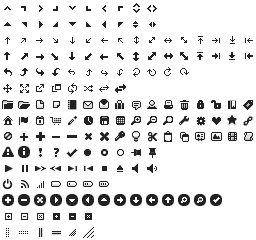
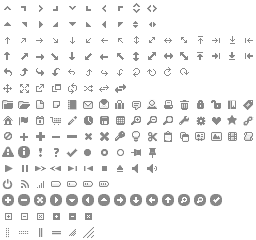
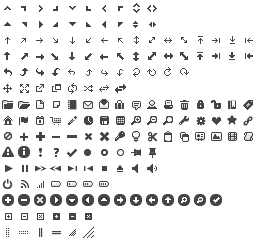
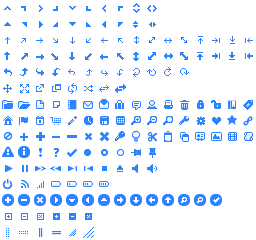
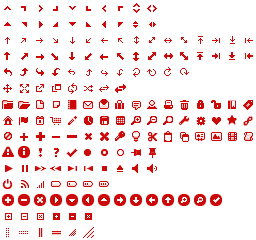
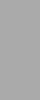
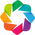
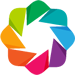

In [1]:
import os
import math
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import *

#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.io import output_notebook
output_notebook()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

- ## Loading Data

***Note : nous chargeons les données qui ont été traitées préalablement depuis le Notebook Ch1, cela évite de devoir réécrire tout le code du premier Notebook dans celui-ci.***

In [2]:
#Récupération de la variable data depuis le Notebook stocké précédemment.
%store -r data

#Pour cette approche nous allons supprimer la colonne des départements
del data['codepostal_']

In [3]:
#Nous n'observons que le début de la table pour s'assurer qu'elle s'est bien chargée.
data.head()

,anc_veh,crm,kmage_annuel,prime_tot_ttc,puis_fiscale,var1,var10,var11,var12,var13,var15,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var9,age,anciennete_permis,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,marque_AUDI,marque_AUTRES,marque_BMW,marque_CHEVROLET,marque_CHRYSLER,marque_CITROEN,marque_DACIA,marque_DAEWOO,marque_DAIHATSU,marque_DODGE,marque_EBRO,marque_ENGIN TRAVAUX PUBLIC,marque_FIAT,marque_FORD,marque_HONDA,marque_HYUNDAI,marque_ISUZU,marque_IVECO,marque_JAGUAR,marque_JEEP,marque_KIA,marque_LADA,marque_LANCIA,marque_LAND-ROVER,marque_LEXUS,marque_MAZDA,marque_MCC,marque_MERCEDES,marque_MG,marque_MINI,marque_MITSUBISHI,marque_NISSAN,marque_NR,marque_OPEL,marque_PEUGEOT,marque_PONTIAC,marque_PORSCHE,marque_RENAULT,marque_ROVER,marque_SAAB,marque_SANTANA,marque_SEAT,marque_SKODA,marque_SMART,marque_SSANGYONG,marque_SUBARU,marque_SUZUKI,marque_TOYOTA,marque_VOLKSWAGEN,marque_VOLVO,profession_agriculteur exploitant,profession_artisan,"profession_cadre, ingenieur",profession_chef d'entreprise,profession_commercant,"profession_contremaitre, agent de maitrise",profession_demandeur d'emploi,"profession_educateur, animateur, moniteur","profession_enseignant, formateur, chercheur",profession_etudiant,profession_homme ou femme au foyer,profession_ouvrier,profession_profession de l'information des arts et des spectacles,profession_profession intermediaire de la sante et du travail social,profession_profession liberale,profession_technicien,var14_B,var14_C,var14_D,var14_E,var14_F,var14_G,var14_N,var16_1,var16_2,var16_3,var16_4,var16_5,var16_NR,var6_B,var6_C,var6_D,var6_N,var7_1,var7_10,var7_11,var7_12,var7_13,var7_14,var7_2,var7_20,var7_3,var7_30,var7_4,var7_5,var7_50,var7_6,var7_7,var7_8,var7_9,var7_NR,var8_B1,var8_B2,var8_F,var8_H1,var8_H2,var8_K,var8_K2,var8_K3,var8_M1,var8_M2,var8_MC,var8_NR,var8_P1,var8_P2,var8_P3,var8_P4,var8_PU,var8_T1,var8_T2,var8_T3,var8_T4,var8_TU,var8_VA
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,68,2924,254.75,4,10.0,155,1,855,3,1,1,27,0,1,0,0,1,372,0,1,60,30.0,10.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,50,11580,259.89,8,10.0,175,2,1490,5,2,1,28,0,1,0,0,1,372,0,1,115,30.0,10.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,95,7149,431.65,7,15.0,170,2,1278,5,3,1,29,0,2,0,0,1,372,0,2,90,34.0,15.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,100,6526,577.99,5,10.0,161,2,1065,5,3,1,29,0,4,0,0,1,372,0,1,75,29.0,10.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,50,2872,222.67,4,3.0,162,2,825,5,2,4,26,0,2,1,1,4,372,2,2,60,22.0,3.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# I. Data management

- ## Fonction de traitement de données

***La donnée étant déjà traité de façon la plus simple depuis le premier Notebook, nous nous contentons pour notre première approche "naïve" de simplement séparer notre base de train afin de pouvoir évaluer le modèle d'apprentissage.***

***Nous la considérons "naïve", dans la mesure où nous nous sommes seulement contentés de remplacer les NaN par la moyenne des valeurs existantes (pour les variables quantitatives). Le traitement des données est indispensable afin que le modèle d'apprentissage accepte le format des données en entrée.***

In [4]:
def simple_split(X):
    to_drop=['prime_tot_ttc']
    T=X[300000:]
    X=X[0:300000]  
    return X.drop(to_drop,axis=1),X.prime_tot_ttc,T.drop(to_drop,axis=1)


- ## Data split

In [5]:
%%time
X,y,T=simple_split(data.copy())

CPU times: user 40 ms, sys: 28 ms, total: 68 ms
Wall time: 64.9 ms


# II. Machine learning

Here comes the juicy part!

***Avant d'entrer dans le coeur du machine learning, il est nécessaire de définir une métrique d'évaluation.***

In [6]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

***Nous allons scinder la base de train afin de pouvoir évaluer le modèle, par l'intermédiaire de la méthode de validation croisée.***

In [7]:
from sklearn.cross_validation import train_test_split
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,test_size=0.3,random_state=42)

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


- ## A. Méthode Linéaire

In [8]:
%%time
#Apprentissage:
lr = LinearRegression()
lr.fit(X0_train, y0_train)

#Prédiction:
y_lr = lr.predict(X0_test)

CPU times: user 16.3 s, sys: 5.65 s, total: 22 s
Wall time: 3.65 s


In [9]:
#lr.coef_

In [10]:
#Evaluation du modèle :
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_lr))

La moyenne absolue de pourcentage d'erreur est de 14.6684527274 %


***Nous obtenons un pourcentage d'erreur d'environ 14,66 %. C'est correct, mais nous ne pouvons pas pour autant nous en contenter, car nous pouvons faire mieux. C'est ce que nous allons voir dans la suite de ce Notebook.***

- ## B. Méthodes non-linéaires : méthodes ensemblistes

***Ici, nous allons faire usage de méthodes non-linéaires d'apprentissage automatique, et nous verrons quelle est la meilleure méthode en termes de performances (notamment en termes de taux d'erreur et de vitesse d'exécution).***

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor 
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

***Commençons par tester la méthode de régression des fôrets d'arbres décisionnels.***

In [12]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=7, n_jobs=-1, max_features=None, min_samples_split=5)
rf.fit(X0_train, y0_train)
y_rf = rf.predict(X0_test)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_rf))

La moyenne absolue de pourcentage d'erreur est de 12.5464378049 %
CPU times: user 23min 7s, sys: 1.39 s, total: 23min 9s
Wall time: 3min 18s


***Nous obtenons un pourcentage d'erreur d'environ 12,5 %. C'est légèrement mieux, mais encore une fois, nous pouvons clairement faire mieux. C'est ce que nous allons voir dans ce qui suit.***

***À présent, testons la méthode de régression extra-trees. Dans un premier temps, portons le nombre d'estimateurs à 20, et une profondeur maximale de 166.***

In [13]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=20, criterion='mse',max_depth=166,n_jobs=-1,
                         min_samples_split=5,max_features=None)
et.fit(X0_train, y0_train)
y_et = et.predict(X0_test)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

La moyenne absolue de pourcentage d'erreur est de 10.3627092237 %
CPU times: user 4min 19s, sys: 328 ms, total: 4min 19s
Wall time: 37.7 s


***Nous obtenons un pourcentage d'erreur d'environ 10,36 %. Nous progressons, mais ce n'est pas encore optimal. Nous allons persévérer.***

***Cette fois, testons toujours la méthode de régression extra-trees, mais cette fois, avec un nombre d'estimateurs plus important (porté à 300), et une profondeur maximale bien plus réduite (profondeur maximale de 7).***

In [14]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=300, criterion='mse',max_depth=7,n_jobs=-1,
                         min_samples_split=5,max_features=None)
et.fit(X0_train, y0_train)
y_et = et.predict(X0_test)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

La moyenne absolue de pourcentage d'erreur est de 14.1409236058 %
CPU times: user 26min 10s, sys: 872 ms, total: 26min 10s
Wall time: 3min 28s


***Nous obtenons un pourcentage d'erreur d'environ 14 %. La réduction importante de la profondeur et la forte augmentation du nombre d'estimateurs n'ont pas porté leurs fruits. L'erreur est meilleure (entendre "plus faible") lorsque la profondeur est importante, mais que le nombre d'estimateurs n'est pas colossal.***

In [15]:
%%time
xg = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X0_train, y0_train)
y_xgb = xg.predict(X0_test)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

La moyenne absolue de pourcentage d'erreur est de 10.3566072286 %
CPU times: user 5min 2s, sys: 860 ms, total: 5min 3s
Wall time: 40.8 s


***Nous obtenons un pourcentage d'erreur d'environ 10,35 %. C'est très légèrement moins bien (écart d'à peine 0,02%) que la première procédure extra-trees.***

In [16]:
%%time
xg = xgb.XGBRegressor(max_depth=8, n_estimators=300, learning_rate=0.075).fit(X0_train, y0_train)
y_xgb = xg.predict(X0_test)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

La moyenne absolue de pourcentage d'erreur est de 8.93157897169 %
CPU times: user 13min 34s, sys: 1.3 s, total: 13min 35s
Wall time: 1min 48s


***Nous obtenons un pourcentage d'erreur d'environ 8,7 %. C'est un progrès net, nous pouvons nous en satisfaire (lorsque nous approchons des 7% d'erreur dans notre cas de figure, nous pouvons considérer que notre modèle d'apprentissage est performant).***

# Stockage de l'arbre de décision

In [17]:
#To store a visual representation of the trees
import graphviz

if not os.path.exists('graph/'):
    os.makedirs('graph/')
a=xgb.to_graphviz(xg, num_trees=2)
#a.engine = 'circo'
a.format = 'png'
a.render('graph/graph.png', view=False)

'graph/graph.png.png'

In [18]:
%%time
dtrain = xgb.DMatrix(X0_train,label=y0_train)
dtest = xgb.DMatrix(X0_test)

params = {'booster':'gbtree', 'eta':0.2, 'max_depth':8, 'subsample':0.8, 'n_estimators':300,
                 'silent':1, 'objective':'reg:linear', "seed":42, 'nhtread':8,
                 'eval_metric':'rmse','colsample_bytree':0.7}
    
xg = xgb.train(params, dtrain, 300)
y_xg = xg.predict(dtest)
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

La moyenne absolue de pourcentage d'erreur est de 8.93157897169 %
CPU times: user 10min 33s, sys: 812 ms, total: 10min 34s
Wall time: 1min 23s


# III. Evaluation du modèle

- ## Plot des features selon leur importance

***Dans cette étape d'évaluation du modèle, nous allons représenter sous la forme d'un diagramme horizontal les 75 variables qui contribuent le plus au modèle, à l'aide de la méthode XGBoost.***

- - ### Modèle XGBoost :

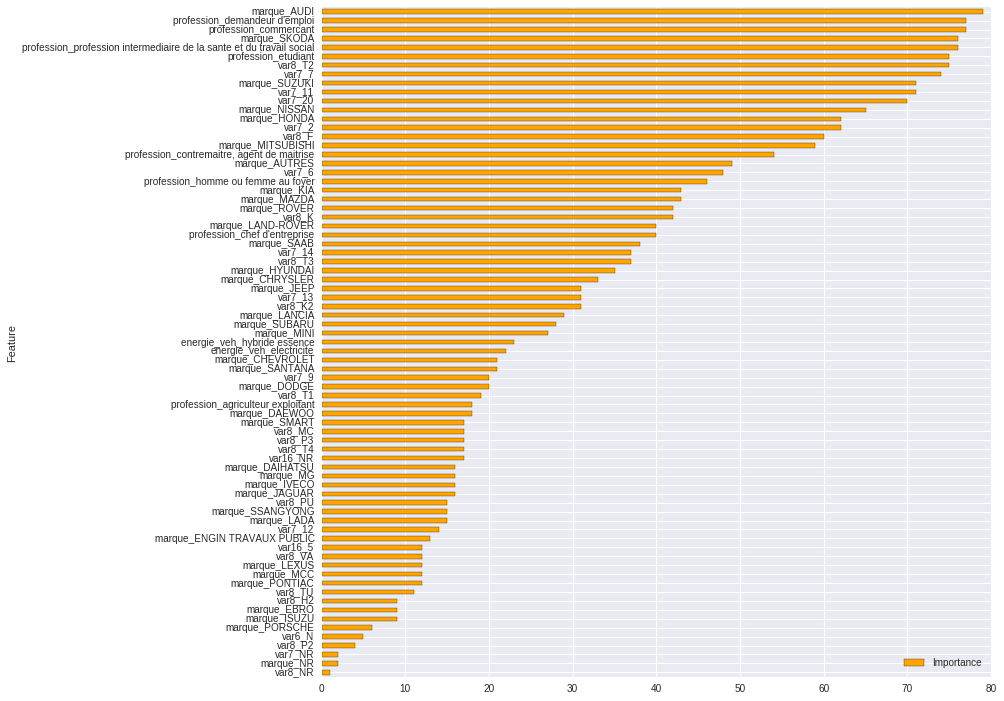

In [19]:
importances = xg.get_score()
importance_frame = pd.DataFrame({'Importance': list(importances.values()),'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:75].plot(kind = 'barh', x = 'Feature', figsize = (12,12), color = 'orange')

***Nous ne sommes pas tellement convaincus par cette représentation, dans la mesure où les interprétations métiers ne sont pas hyper évidentes (bien qu'il y ait des différences entre les variables, aucune d'entre elles ne se taille la part du lion en termes d'importance).***

- - ### Modèle Random Forest :

***Dans cette étape d'évaluation du modèle, nous allons représenter sous la forme d'un diagramme horizontal les 100 variables qui contribuent le plus au modèle, à l'aide de la méthode Random Forest.***

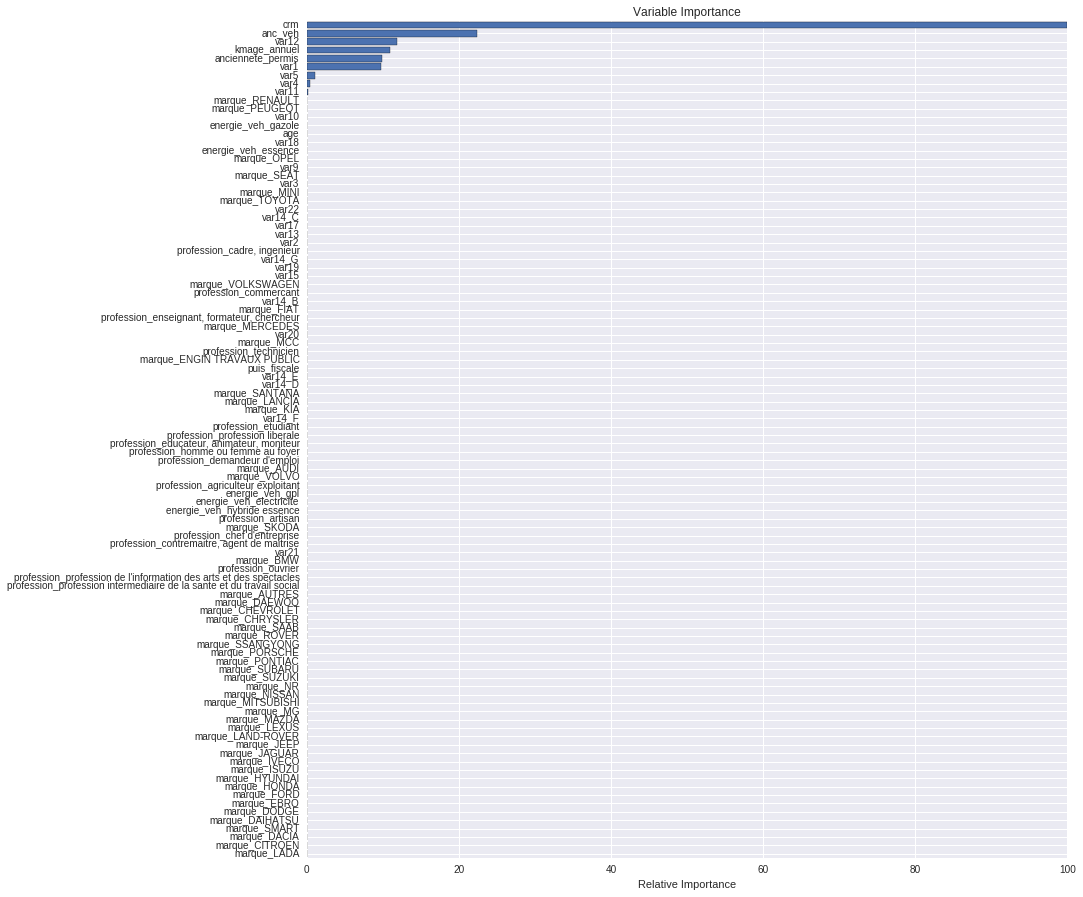

In [20]:
# Plot feature importance depuis le modèle Random Forest et non XGBoost.
feature_importance =rf.feature_importances_[0:100]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(30,15))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos,[list(X0_train.columns.values)[x] for x in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

***La représentation est clairement meilleure : nous arrivons mieux à distinguer l'importance relative de chacune des variables. En effet, les variables "crm", "anc_veh", "var12" (pour rappel, nous ne connaissons pas sa signification comme toutes les variables intitulées "var..."), "kmage_annuel", "var1", et "anciennete_permis" se taillent la part du lion en termes de contribution au modèle ("var5", "var4", et "var11" se partagent quant à elles les miettes). Remarquez que l'importance de "crm" est de 100% : cela peut paraître mathématiquement insensé, mais c'est parfaitement normal au vu de la définition de notre fonction "feature_importance" (feature_importance.max() n'est autre que "crm"). Nous parlons bien d'importance relative (sous-entendu relativement à "crm").***

# IV. Soumission des résultats

In [21]:
path='prediction/Approche Naive/'

In [22]:
def write_to_file(X_prod,y_pred,name_file,path) :
    if not os.path.exists(path):
        os.makedirs(path)
    X_prod['COTIS'] = y_pred
    X_prod[['COTIS']].to_csv(path+name_file, index=True, sep=';')

In [ ]:
%%time
xg = xgb.XGBRegressor(max_depth=8, n_estimators=300, learning_rate=0.075).fit(X, y)
y_xg = xg.predict(T)
write_to_file(T.copy(), y_xg,'ma_prediction_XGB.csv',path)

CPU times: user 19min 40s, sys: 1.66 s, total: 19min 42s
Wall time: 2min 38s


In [ ]:
%%time
##prend du temps
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=300, max_depth=8, max_features=None, min_samples_split=5)
gb.fit(X, y)
y_gb = gb.predict(T)
write_to_file(T.copy(), y_gb,'ma_prediction_GB.csv',path)

In [ ]:
%%time
#blending
y_blend=0.5*y_xg+0.5*y_gb
write_to_file(T.copy(), y_blend,'ma_prediction_blended.csv',path)

In [ ]:
submited=pd.read_csv(path+'ma_prediction_blended.csv', sep=';')
submited.head()